---
layout: page
title: Retirement Burndown
---

## How much do I need to retire?

There are two primary components:

- How much are my annual expenses?
- How many years of retirement?

These two components help resolve the original question:

- Will I have enough superannuation fund to cover these expenses during retirement?

In [1]:
import sys
sys.path.insert(0, '../src')
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from IPython.display import display, Markdown

## Retirement Expenses

This data model is based on annual retirement expense data from the [Association of Superannuation Funds of Australia](retirement-planning.md). Expenses are plotted for different 'lifestyle' scenarios:

In [2]:
""" Chart variables """
# annual expenses source retirement-planning.md
# this is also simplified - expenses typically reduce after age 85 when most people have a less active lifestyle.
annual_expenses = {
    "modest": {
        "expenses": 45000,
        "color": "red",
    },
    "comfortable": {
        "expenses": 70000,
        "color": "orange",
    },
    "four-star": {
        "expenses": 90000,
        "color": "green",
    },
    "luxury": {
        "expenses": 140000,
        "color": "blue",
    },
    "opulent": {
        "expenses": 230000,
        "color": "darkviolet",
    },
}

# Create a Markdown table
table = "| Lifestyle | " + " | ".join(key.capitalize() for key in annual_expenses.keys()) + " |\n"
table += "|-----------|" + "|".join("--:" for _ in annual_expenses.keys()) + "|\n"
table += "| Annual    | " + "| ".join("${:,}".format(value['expenses']) for value in annual_expenses.values()) + " |\n"
table += "| Monthly   | " + "| ".join("${:,.0f}".format(round(value['expenses']/12, -2)) for value in annual_expenses.values()) + " |"

# Display the table
display(Markdown(table))

# TODO: add data for singles/couples and different ages

| Lifestyle | Modest | Comfortable | Four-star | Luxury | Opulent |
|-----------|--:|--:|--:|--:|--:|
| Annual    | $45,000| $70,000| $90,000| $140,000| $230,000 |
| Monthly   | $3,800| $5,800| $7,500| $11,700| $19,200 |

In [3]:
life_expectancy = 100
retirement_age = 50 
retirement_years = life_expectancy - retirement_age +1 # add 1 to include year of retirement in range

display(Markdown(f"""
The chart below shows the cumulative retirement expenses for up to {retirement_years - 1} years of retirement:
"""))


The chart below shows the cumulative retirement expenses for up to 50 years of retirement:


In [4]:
""" Data manipulation """

# Create a DataFrame with number of rows = retirement_years
df = pd.DataFrame(index=np.arange(retirement_years))

for i in range(retirement_years):
    df['year'] = retirement_years - df.index -1
    df['age'] = life_expectancy - df.index

# For each key in annual_expenses, create a column
for lifestyle, details in annual_expenses.items():
    # Each year the values increase by the related annual_expenses value
    df[lifestyle.capitalize()] = df.index * details['expenses']
    


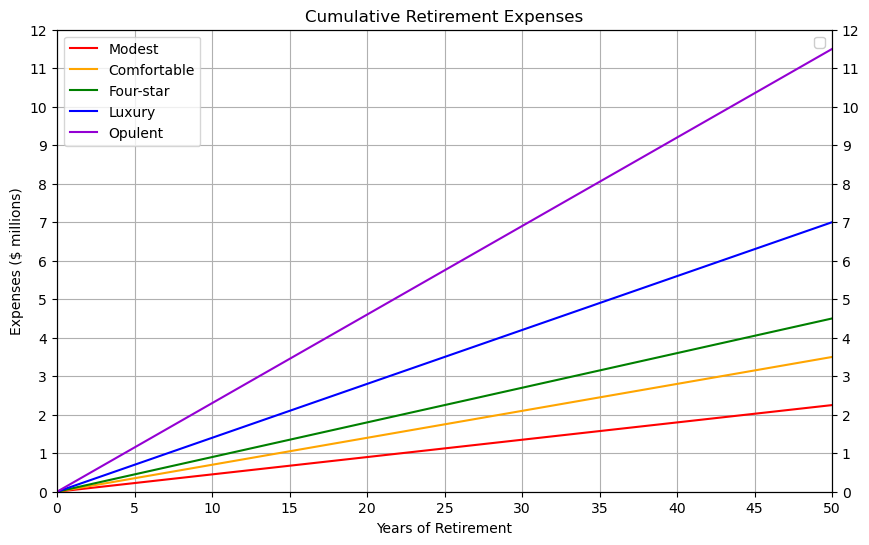

In [5]:
""" Basic chart """
# create a new dataframe with only the annual_expense columns
df_burndown = df[list(key.capitalize() for key in annual_expenses.keys())]

# create a list of colors for each lifestyle
colors = [details['color'] for details in annual_expenses.values()]

# plot the dataframe with the specified colors
df_burndown.plot(figsize=(10, 6), color=colors)

ax = plt.gca()
plt.xlabel('Years of Retirement')
plt.ylabel('Expenses ($ millions)')
plt.title('Cumulative Retirement Expenses')
plt.grid(True)
plt.xlim(0, retirement_years-1)
plt.ylim(ymin=0, ymax=12e6)
# Format x-axis ticks every x years
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
# Format y-axis ticks every 1 million
ax.yaxis.set_major_locator(ticker.MultipleLocator(1e6))
# with labels formatted in millions with no decimal places
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x*1e-6)))
# clone y axis to right side of chart
#ax.tick_params(axis='y', which='both', right=True)
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1e6))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x*1e-6)))
#ax2.set_yticklabels(ax.get_yticklabels())
legend_labels = df_burndown.columns
plt.legend(legend_labels).get_frame().set_alpha(0.98)
plt.show()

This model excludes inflation, the true funds required would be much higher as expenses will increase over time. Inflation will be added to the model in a later stage.

Even a modest retirement requires millions of dollars of expenses. Hopefully superanuation can pay for these expenses.

## Superanuation Returns and Performance

In [6]:
""" Yield Appreciation """

Yield = {
    "bear": 6,
    "base": 10,
    "bull": 18,
}

In [7]:
def human_format(x, pos):
    magnitude = 0
    while abs(x) >= 1000:
        magnitude += 1
        x /= 1000.0
    return '%.1f%s' % (x, ['', 'k', 'm', 'b'][magnitude])

In [8]:
columns = ['initial', 'yield', 'eoy', 'expenses', 'balance']
df_yield = pd.DataFrame(index=np.arange(retirement_years))

for yield_name, yield_rate in Yield.items():

    for lifestyle in annual_expenses.keys():    
        expenses = annual_expenses[lifestyle]['expenses'] * -1

        # prefix the lifestyle to each column name
        lifestyle_columns = [f'{lifestyle}_{yield_name}_{column}' for column in columns]
        for column in lifestyle_columns:
            df_yield[column] = 0

        for i in range(retirement_years):
            df_yield[f'{lifestyle}_{yield_name}_initial'] = df_yield[f'{lifestyle}_{yield_name}_eoy'] / (1 + (yield_rate / 100))
            df_yield[f'{lifestyle}_{yield_name}_balance'] = np.where(df.index == 0, 0, df_yield[f'{lifestyle}_{yield_name}_initial'].shift())
            df_yield[f'{lifestyle}_{yield_name}_expenses'] = expenses
            df_yield[f'{lifestyle}_{yield_name}_eoy'] = df_yield[f'{lifestyle}_{yield_name}_balance'] - df_yield[f'{lifestyle}_{yield_name}_expenses']
            df_yield[f'{lifestyle}_{yield_name}_yield'] = df_yield[f'{lifestyle}_{yield_name}_initial'] * (yield_rate / 100)

Australian superannuation fund performance has been analysed by [superguide.com.au](https://www.superguide.com.au/comparing-super-funds/super-funds-returns-financial-year). Over a 15 year time period, the median performing superannuation fund (with a 'growth' risk portfolio) increased 7.8% per year. 

The median performing 'growth' risk funds should at least be able to match the baseline performance of the S&P 500 index. High performing funds and those with a 'high growth' risk portfolio should be expected to out-perform the S&P 500 index by selecting a subset of high performing companies, and investing in a small set of high growth, high risk stocks.

> ℹ Over a 30 year time period the S&P 500 index has a median increase of around 12% per year.

In [9]:
ex_yield_rate = 10 # example with 10%
ex_lifestyle = list(annual_expenses.keys())[1]
ex_expenses = annual_expenses[ex_lifestyle]['expenses'] 
ex_fund = ex_expenses * ex_yield_rate

display(Markdown(f"""
Lets start an example with a retirement fund yield or appreciation of {ex_yield_rate}% per year.

A retirement fund of ${format(ex_fund,',')} will increase by ${format(ex_expenses,',')} per year, 
enough to cover the {ex_lifestyle} lifestyle annual expenses of ${format(ex_expenses,',')} per year.

A retirement fund slightly less than ${format(ex_fund,',')} will decrease in value over time and eventually reach zero.
"""))


Lets start an example with a retirement fund yield or appreciation of 10% per year.

A retirement fund of $700,000 will increase by $70,000 per year, 
enough to cover the comfortable lifestyle annual expenses of $70,000 per year.

A retirement fund slightly less than $700,000 will decrease in value over time and eventually reach zero.


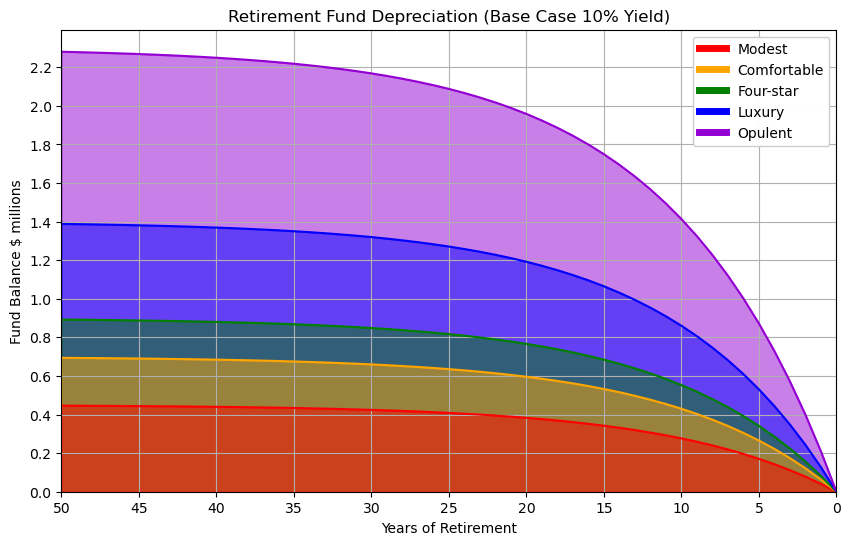

In [10]:
yield_name = 'base'
df_burndown = df_yield[[column for column in df_yield.columns if column.endswith(yield_name + '_balance')]]

# create a list of colors for each lifestyle
colors = [details['color'] for details in annual_expenses.values()]

# plot the dataframe with the specified colors
df_burndown.plot(figsize=(10, 6), color=colors)

# reverse the x-axis to burndown instead of burnup
ax = plt.gca()
ax.invert_xaxis()

for column, color in zip(reversed(df_burndown.columns), reversed(colors)):
    ax.fill_between(df_burndown.index, df_burndown[column], color=color, alpha=0.5)

plt.xlabel('Years of Retirement')
plt.ylabel('Fund Balance $ millions')
plt.title(f'Retirement Fund Depreciation ({yield_name.capitalize()} Case {Yield[yield_name]}% Yield)')
plt.grid(True)
plt.xlim([retirement_years-1, 0])
plt.ylim(ymin=0) #, ymax=12e6)
# Format x-axis ticks every x years
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
# Format y-axis ticks every 100,000 with major tick labels
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(2e5))
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1e6))
# with labels formatted in millions with no decimal places
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.1f}'.format(x*1e-6)))

# set the legend labels to match the column name prefix before the '_' character
legend_labels = [label.split('_')[0].capitalize() for label in df_burndown.columns]
#set the legend labels in the plt.legend
legend = plt.legend(legend_labels)
legend.get_frame().set_alpha(0.98)
for line in legend.get_lines():
    line.set_linewidth(5)
plt.show()

Superanuation fund performance can fluctuate year to year with international ecomonic trends and stock market volatility. A fund that has consistently better or worse performance over a multi-year period will have significant impact - if consistently sustained over that long time period.

A fund of $700,000 with a base return of 10% could support a comfortable retirement for 50 years. A high performing fund with a consistent return of 18% could could jump two lifestyle levels and support a near-luxury retirement for 50 years.

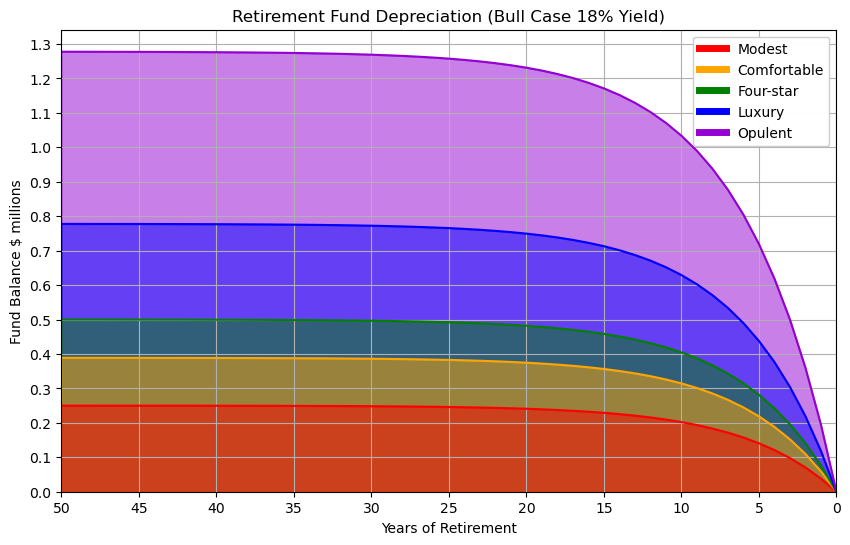

In [11]:
yield_name = 'bull'
df_burndown = df_yield[[column for column in df_yield.columns if column.endswith(yield_name + '_balance')]]

# create a list of colors for each lifestyle
colors = [details['color'] for details in annual_expenses.values()]

# plot the dataframe with the specified colors
df_burndown.plot(figsize=(10, 6), color=colors)

# reverse the x-axis to burndown instead of burnup
ax = plt.gca()
ax.invert_xaxis()

for column, color in zip(reversed(df_burndown.columns), reversed(colors)):
    ax.fill_between(df_burndown.index, df_burndown[column], color=color, alpha=0.5)

plt.xlabel('Years of Retirement')
plt.ylabel('Fund Balance $ millions')
plt.title(f'Retirement Fund Depreciation ({yield_name.capitalize()} Case {Yield[yield_name]}% Yield)')
plt.grid(True)
plt.xlim([retirement_years-1, 0])
plt.ylim(ymin=0) #, ymax=12e6)
# Format x-axis ticks every x years
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
# Format y-axis ticks every 100,000 with major tick labels
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1e5))
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1e6))
# with labels formatted in millions with no decimal places
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.1f}'.format(x*1e-6)))

# set the legend labels to match the column name prefix before the '_' character
legend_labels = [label.split('_')[0].capitalize() for label in df_burndown.columns]
#set the legend labels in the plt.legend
legend = plt.legend(legend_labels)
legend.get_frame().set_alpha(0.98)
for line in legend.get_lines():
    line.set_linewidth(5)
plt.show()

The chart below illustrates the overlapping lifestyle curves at different peformance levels. Generally a sustained high performing return will move up one lifestyle curve, and a sustained low performing return will move down one lifestyle curve.

These expenses still do not take inflation into consideration, however the fund performance is the greatest factor in determining retirement income.

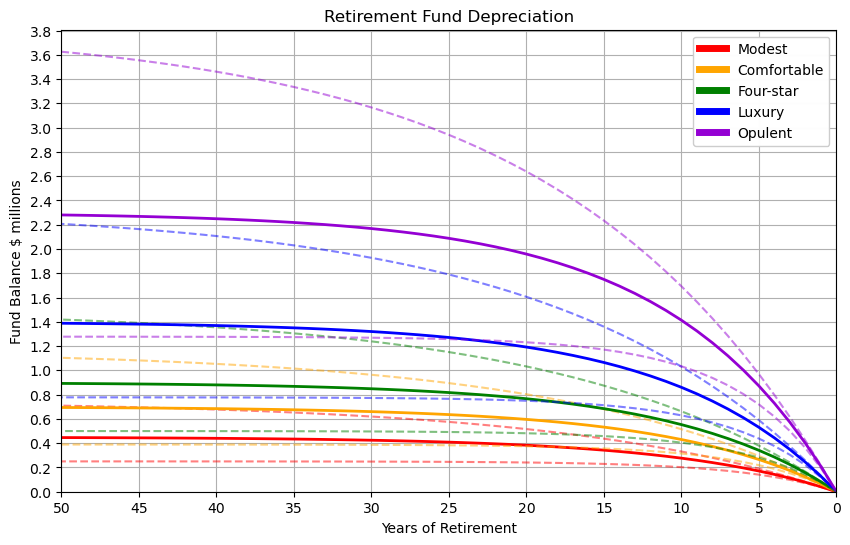

In [12]:
df_burndown = df_yield[[column for column in df_yield.columns if column.endswith('_balance')]]

# create a list of colors for each lifestyle
colors = [details['color'] for details in annual_expenses.values()]

# plot the dataframe with the specified colors
df_burndown.plot(figsize=(10, 6), color=colors)

# reverse the x-axis to burndown instead of burnup
ax = plt.gca()
ax.invert_xaxis()

for line in ax.lines:
    # if the line's label contains 'median', set the line style to solid
    if 'base' in line.get_label():
        line.set_linewidth(2)
    else:
        line.set_linestyle('--')
        line.set_alpha(0.5)

#for column, color in zip(reversed(df_burndown.columns), reversed(colors)):
#    ax.fill_between(df_burndown.index, df_burndown[column], color=color, alpha=0.1)

plt.xlabel('Years of Retirement')
plt.ylabel('Fund Balance $ millions')
plt.title('Retirement Fund Depreciation')
plt.grid(True)
plt.xlim([retirement_years-1, 0])
plt.ylim(ymin=0) #, ymax=12e6)
# Format x-axis ticks every x years
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
# Format y-axis ticks every 100,000 with major tick labels
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(2e5))
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1e6))
# with labels formatted in millions with no decimal places
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.1f}'.format(x*1e-6)))

# set the legend labels to match the column name prefix before the '_' character
#set the legend labels in the plt.legend

handles, labels = ax.get_legend_handles_labels()
base_handles = [handle for handle, label in zip(handles, labels) if 'base' in label]
base_labels = [label.split('_')[0].capitalize() for label in labels if 'base' in label]

legend = plt.legend(base_handles, base_labels)
legend.get_frame().set_alpha(0.98)
for line in legend.get_lines():
    line.set_linewidth(5)

plt.show()

## Inflation

In [13]:
# Open the file
with open('../data/inflation_percentiles.md', 'r') as file:
    # Read the file
    inflation_percentiles = file.read()

# Replace headings for percentile column headings
updated_headings_row = '| Years | Lower | Median | Upper |'
inflation_percentile_table = inflation_percentiles.replace(inflation_percentiles.split('\n')[0], updated_headings_row, 1)

# Print the markdown table
print(inflation_percentile_table)

| Years | Lower | Median | Upper |
|-------|-----:|-----:|-----:|
| 1     | 5.08 | 5.70 | 6.25 |
| 10    | 1.50 | 1.90 | 3.12 |
| 30    | 1.70 | 2.45 | 3.23 |



In [14]:
# No easy python method to convert markdown table to dataframe so reload the file as csv
dfInflation = pd.read_csv('../data/inflation_percentiles.md', sep='|', skipinitialspace=True, skiprows=[1])
# Drop the first and last (empty) columns due to how the markdown table is imported
dfInflation = dfInflation.iloc[:, 1:-1]  
# Remove leading/trailing white spaces from column names
dfInflation.columns = dfInflation.columns.str.strip()
# Remove leading/trailing white spaces from data
dfInflation = dfInflation.map(lambda x: x.strip() if isinstance(x, str) else x)
dfInflation.set_index('Years', inplace=True)

In [15]:
dfInflation_rate_headings = ['lower', 'median', 'upper']
dfInflation.columns = dfInflation_rate_headings
dfInflation_rate =  dfInflation.iloc[-1]/100
dfInflation_rate.median()

0.0245

In [16]:
""" Inflation adjusted chart """
# multi year inflation from last row
inflation_rate =  dfInflation.iloc[-1]/100

# for each dfInflation_rate column, add a new column to the df dataframe for the inflation adjusted expenses
#for inflation_heading in dfInflation_rate_headings:
#    df[f'comfortable_{inflation_heading}_inflation'] = np.where(df.index == 0, 0, (0 - annual_expenses['comfortable']['expenses']) * (1 + inflation_rate[inflation_heading]) ** (df.index -1) )
#    df[f'comfortable_{inflation_heading}_balance'] = (df[f'comfortable_{inflation_heading}_inflation']*-1).cumsum()

# for each lifestyle in annual_expenses.keys()
for lifestyle in annual_expenses.keys():
    # for each dfInflation_rate column, add a new column to the df dataframe for the inflation adjusted expenses
    for inflation_heading in dfInflation_rate_headings:
        df[f'{lifestyle}_{inflation_heading}_inflation'] = np.where(df.index == 0, 0, (0 - annual_expenses[lifestyle]['expenses']) * (1 + inflation_rate[inflation_heading]) ** (df.index -1) )
        df[f'{lifestyle}_{inflation_heading}_balance'] = (df[f'{lifestyle}_{inflation_heading}_inflation']*-1).cumsum()



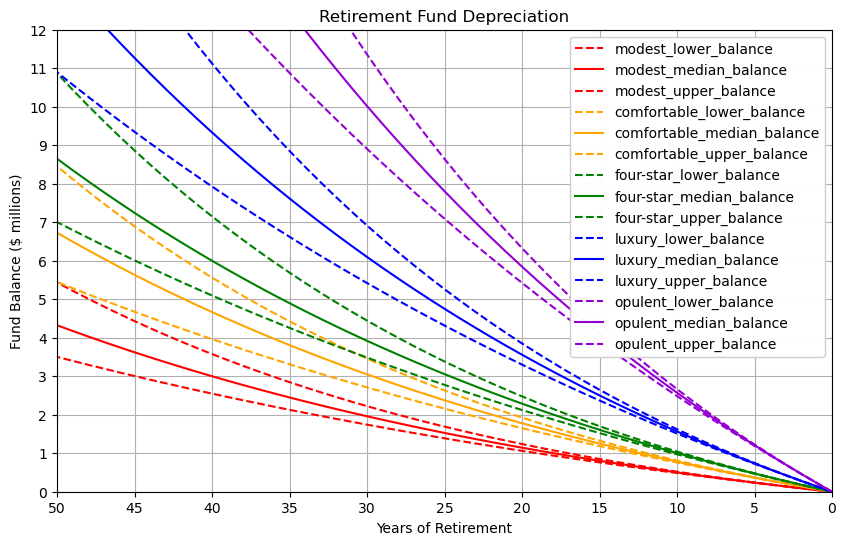

In [18]:
""" Basic chart """
# create a new dataframe with only the annual_expense columns
#df_burndown = df[list(key+'_balance' for key in annual_expenses.keys())]
#df_burndown = df[list(f'comfortable_{inflation_heading}_balance' for inflation_heading in inflation_rate_headings)]
df_burndown = df[[column for column in df.columns if column.endswith('_balance')]]

# create a list of colors for each lifestyle
colors = [details['color'] for details in annual_expenses.values()]
colors = [color for color in colors for _ in range(3)]

# plot the dataframe with the specified colors
df_burndown.plot(figsize=(10, 6), color=colors)

# reverse the x-axis to burndown instead of burnup
ax = plt.gca()
ax.invert_xaxis()

for line in ax.lines:
    # if the line's label contains 'median', set the line style to solid
    if 'median' not in line.get_label():
        line.set_linestyle('--')

plt.xlabel('Years of Retirement')
plt.ylabel('Fund Balance ($ millions)')
plt.title('Retirement Fund Depreciation')
plt.grid(True)
plt.xlim([retirement_years-1, 0])
plt.ylim(ymin=0, ymax=12e6)
# Format x-axis ticks every x years
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
# Format y-axis ticks every 1 million
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1e6))
# with labels formatted in millions with no decimal places
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x*1e-6)))
plt.legend().get_frame().set_alpha(0.98)
plt.show()